# Lý thuyết

1. Tại sao các mô hình deep learning lại chiếm ưu thế hơn so với các mô hình machine learning truyền thống đối với dữ liệu lớn ?

    A. Do mô hình deep learning có thể được thiết kế với kích thước tùy ý nên có khả năng xấp xỉ mọi hàm số. Do đó nó có khả năng biểu diễn tốt và hoạt động hiệu quả trên dữ liệu lớn.

2. Ý nghĩa của hàm loss function trong mạng neural network là gì ?

    B. Mục tiêu của quá trình huấn luyện là tối thiểu hóa hàm loss function bằng thuật toán gradient descent. Giá trị của hàm số này giúp đo lường mức độ khớp của dự báo từ mô hình trên dữ liệu huấn luyện.

3. Khi huấn luyện trên các bộ dữ liệu bigdata thì chúng ta nên sử dụng phương pháp nào ?

    C) Mini-batch gradient descent huấn luyện mô hình trên từng tập dữ liệu con có kích thước nhỏ hơn memory CPU/GPU.
    

4. Quá trình feed forward và backpropagation thực hiện những gì ?

    A) feed forward tính toán output và loss function, backpropagation tính đạo hàm trên từng layer và cập nhật trọng số.

5. Tác dụng của batch normalization là gì ?
    
    D) Giảm thiểu ảnh hưởng của input distribution shift nhằm giúp huấn luyện loss function nhanh và ổn định hơn.
    

# Thực hành

#### 6) Thay đổi hàm loss function, batch size và optimizer.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/machine_learning_hand_On_DS/kaggle/income"
# OS.chdir(path)
%cd {path}

Mounted at /content/drive
/content/drive/My Drive/machine_learning_hand_On_DS/kaggle/income


In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.10.0+cu111


In [ ]:
import numpy as np
import random
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
seed = 42 
seed_all(seed)

In [ ]:
#metric
def get_metrics(y_test, y_pred):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred),'\n')
    print(classification_report(y_test, y_pred, digits=4), '\n')

In [ ]:
df_all = pd.read_csv('train.csv')

In [ ]:
# normalize string
def str_normalize(s):
    # convert into lowercase and replace multiple spaces into single space
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s
# Encode category and object columns 
def process(df):        
  for col in df.columns:
      if df[col].dtype.name == "object" or df[col].dtype.name == "category":
          df[col] = df[col].apply(str_normalize).astype("category")
  return df
df_all = process(df_all.copy())
IDs=df_all.pop('ID')
label = df_all.pop('target_income')
df_all_one_hot = pd.get_dummies(df_all)

In [ ]:
features = df_all_one_hot.columns.tolist()
label = label.values

In [ ]:
features = df_all_one_hot.columns.tolist()

x_train, x_test, y_train, y_test = train_test_split(df_all_one_hot[features].values, # input variable
                                                    label, # output variable
                                                    test_size=0.2, # test dataset proportion
                                                    # stratify=df_all['target_income'], # assign equal proportion of target label in train/test 
                                                    random_state=0) # keep train/test split the same if run again. 
print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
#normalize
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Training Set: 20000, Test Set: 5000 



In [ ]:
hl = 50
# Define the neural network
class IncomeNet(nn.Module):
    def __init__(self):
        super(IncomeNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.nn.Softmax()(self.fc3(x))
        return x



In [ ]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward: calculate y_pred and loss function
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate: compute gradient descent and update weights
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            predicted = torch.tensor(out.data[:,1] >= 0.5).float()
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

##### batch_size = 64, adam

In [ ]:
# batch_size=64
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=64,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=64,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.487801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation set: Average loss: 0.458362, Accuracy: 4232/5000 (85%)

Epoch: 2
Training set: Average loss: 0.454245
Validation set: Average loss: 0.452623, Accuracy: 4260/5000 (85%)

Epoch: 3
Training set: Average loss: 0.449317
Validation set: Average loss: 0.453323, Accuracy: 4261/5000 (85%)

Epoch: 4
Training set: Average loss: 0.446011
Validation set: Average loss: 0.453164, Accuracy: 4257/5000 (85%)

Epoch: 5
Training set: Average loss: 0.444069
Validation set: Average loss: 0.450840, Accuracy: 4280/5000 (86%)

Epoch: 6
Training set: Average loss: 0.441352
Validation set: Average loss: 0.451000, Accuracy: 4279/5000 (86%)

Epoch: 7
Training set: Average loss: 0.439621
Validation set: Average loss: 0.451735, Accuracy: 4261/5000 (85%)

Epoch: 8
Training set: Average loss: 0.438430
Validation set: Average loss: 0.449513, Accuracy: 4282/5000 (86%)

Epoch: 9
Training set: Average loss: 0.437326
Validation set: Average loss: 0.451250, Accuracy: 4279/5000 (86%)

Epoch: 10
Training set: Avera

Evaluation on test dataset
ACCURACY_SCORE:  0.848
F1_SCORE:  0.7758
CONFUSION_MATRIX:
 [[3539  272]
 [ 488  701]] 

              precision    recall  f1-score   support

           0     0.8788    0.9286    0.9030      3811
           1     0.7205    0.5896    0.6485      1189

    accuracy                         0.8480      5000
   macro avg     0.7996    0.7591    0.7758      5000
weighted avg     0.8412    0.8480    0.8425      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


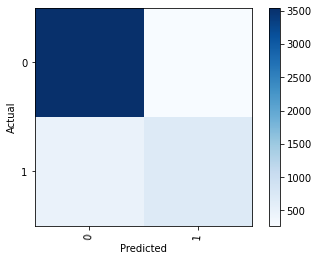

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# batch_size = 64
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 256, adam

In [ ]:
# batch_size=256
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=256,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=256,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.538782
Validation set: Average loss: 0.472816, Accuracy: 4174/5000 (83%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.464623
Validation set: Average loss: 0.457728, Accuracy: 4228/5000 (85%)

Epoch: 3
Training set: Average loss: 0.454481
Validation set: Average loss: 0.455806, Accuracy: 4245/5000 (85%)

Epoch: 4
Training set: Average loss: 0.451621
Validation set: Average loss: 0.453642, Accuracy: 4245/5000 (85%)

Epoch: 5
Training set: Average loss: 0.448947
Validation set: Average loss: 0.452540, Accuracy: 4260/5000 (85%)

Epoch: 6
Training set: Average loss: 0.446560
Validation set: Average loss: 0.452169, Accuracy: 4266/5000 (85%)

Epoch: 7
Training set: Average loss: 0.444960
Validation set: Average loss: 0.453201, Accuracy: 4258/5000 (85%)

Epoch: 8
Training set: Average loss: 0.444587
Validation set: Average loss: 0.451738, Accuracy: 4257/5000 (85%)

Epoch: 9
Training set: Average loss: 0.443018
Validation set: Average loss: 0.451996, Accuracy: 4257/5000 (85%)

Epoch: 10
Training set: Average loss: 0.440150
Validation set: Average loss: 0.451562, Accuracy: 4264/500

Evaluation on test dataset
ACCURACY_SCORE:  0.8516
F1_SCORE:  0.7839
CONFUSION_MATRIX:
 [[3528  283]
 [ 459  730]] 

              precision    recall  f1-score   support

           0     0.8849    0.9257    0.9048      3811
           1     0.7206    0.6140    0.6630      1189

    accuracy                         0.8516      5000
   macro avg     0.8028    0.7699    0.7839      5000
weighted avg     0.8458    0.8516    0.8473      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


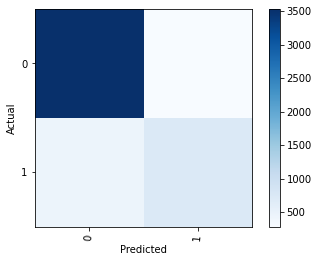

In [ ]:
# batch_size = 256
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 512, adam

In [ ]:
# batch_size=512
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=512,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=512,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.419391
Validation set: Average loss: 0.456438, Accuracy: 4260/5000 (85%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.416339
Validation set: Average loss: 0.457602, Accuracy: 4252/5000 (85%)

Epoch: 3
Training set: Average loss: 0.421224
Validation set: Average loss: 0.456650, Accuracy: 4263/5000 (85%)

Epoch: 4
Training set: Average loss: 0.415659
Validation set: Average loss: 0.458089, Accuracy: 4255/5000 (85%)

Epoch: 5
Training set: Average loss: 0.415813
Validation set: Average loss: 0.458009, Accuracy: 4257/5000 (85%)

Epoch: 6
Training set: Average loss: 0.416940
Validation set: Average loss: 0.457347, Accuracy: 4257/5000 (85%)

Epoch: 7
Training set: Average loss: 0.418965
Validation set: Average loss: 0.457033, Accuracy: 4262/5000 (85%)

Epoch: 8
Training set: Average loss: 0.416127
Validation set: Average loss: 0.458889, Accuracy: 4248/5000 (85%)

Epoch: 9
Training set: Average loss: 0.418610
Validation set: Average loss: 0.457002, Accuracy: 4259/5000 (85%)

Epoch: 10
Training set: Average loss: 0.416763
Validation set: Average loss: 0.457493, Accuracy: 4254/500

Evaluation on test dataset
ACCURACY_SCORE:  0.8482
F1_SCORE:  0.7808
CONFUSION_MATRIX:
 [[3507  304]
 [ 455  734]] 

              precision    recall  f1-score   support

           0     0.8852    0.9202    0.9024      3811
           1     0.7071    0.6173    0.6592      1189

    accuracy                         0.8482      5000
   macro avg     0.7961    0.7688    0.7808      5000
weighted avg     0.8428    0.8482    0.8445      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


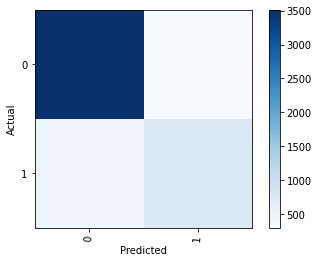

In [ ]:
# batch_size = 512
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 64, RMSprop

In [ ]:
# batch_size=64
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=64,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=64,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.466983
Validation set: Average loss: 0.456981, Accuracy: 4224/5000 (84%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.452023
Validation set: Average loss: 0.452600, Accuracy: 4260/5000 (85%)

Epoch: 3
Training set: Average loss: 0.448692
Validation set: Average loss: 0.450561, Accuracy: 4280/5000 (86%)

Epoch: 4
Training set: Average loss: 0.445808
Validation set: Average loss: 0.449843, Accuracy: 4281/5000 (86%)

Epoch: 5
Training set: Average loss: 0.443640
Validation set: Average loss: 0.451664, Accuracy: 4263/5000 (85%)

Epoch: 6
Training set: Average loss: 0.441492
Validation set: Average loss: 0.451301, Accuracy: 4269/5000 (85%)

Epoch: 7
Training set: Average loss: 0.440535
Validation set: Average loss: 0.450625, Accuracy: 4273/5000 (85%)

Epoch: 8
Training set: Average loss: 0.439390
Validation set: Average loss: 0.451592, Accuracy: 4258/5000 (85%)

Epoch: 9
Training set: Average loss: 0.438086
Validation set: Average loss: 0.450772, Accuracy: 4262/5000 (85%)

Epoch: 10
Training set: Average loss: 0.436909
Validation set: Average loss: 0.452041, Accuracy: 4267/500

Evaluation on test dataset
ACCURACY_SCORE:  0.8492
F1_SCORE:  0.7849
CONFUSION_MATRIX:
 [[3490  321]
 [ 433  756]] 

              precision    recall  f1-score   support

           0     0.8896    0.9158    0.9025      3811
           1     0.7019    0.6358    0.6673      1189

    accuracy                         0.8492      5000
   macro avg     0.7958    0.7758    0.7849      5000
weighted avg     0.8450    0.8492    0.8466      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


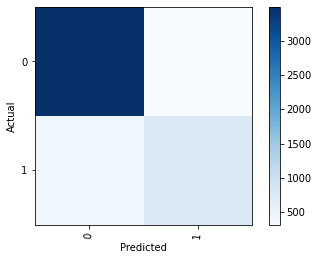

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# batch_size = 64
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 256, RMSprop

In [ ]:
# batch_size=256
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=256,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=256,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.480722
Validation set: Average loss: 0.459382, Accuracy: 4216/5000 (84%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.455353
Validation set: Average loss: 0.455501, Accuracy: 4243/5000 (85%)

Epoch: 3
Training set: Average loss: 0.448969
Validation set: Average loss: 0.455332, Accuracy: 4236/5000 (85%)

Epoch: 4
Training set: Average loss: 0.446884
Validation set: Average loss: 0.453431, Accuracy: 4260/5000 (85%)

Epoch: 5
Training set: Average loss: 0.445984
Validation set: Average loss: 0.452788, Accuracy: 4249/5000 (85%)

Epoch: 6
Training set: Average loss: 0.443985
Validation set: Average loss: 0.456142, Accuracy: 4239/5000 (85%)

Epoch: 7
Training set: Average loss: 0.443077
Validation set: Average loss: 0.454968, Accuracy: 4241/5000 (85%)

Epoch: 8
Training set: Average loss: 0.440277
Validation set: Average loss: 0.453084, Accuracy: 4254/5000 (85%)

Epoch: 9
Training set: Average loss: 0.439142
Validation set: Average loss: 0.452235, Accuracy: 4257/5000 (85%)

Epoch: 10
Training set: Average loss: 0.438929
Validation set: Average loss: 0.451680, Accuracy: 4268/500

Evaluation on test dataset
ACCURACY_SCORE:  0.849
F1_SCORE:  0.7738
CONFUSION_MATRIX:
 [[3564  247]
 [ 508  681]] 

              precision    recall  f1-score   support

           0     0.8752    0.9352    0.9042      3811
           1     0.7338    0.5728    0.6434      1189

    accuracy                         0.8490      5000
   macro avg     0.8045    0.7540    0.7738      5000
weighted avg     0.8416    0.8490    0.8422      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


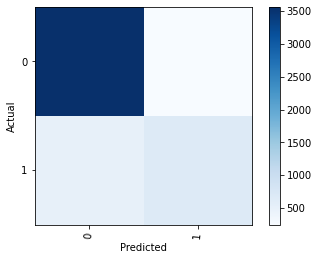

In [ ]:
# batch_size = 256
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 512, RMSprop

In [ ]:
# batch_size=64
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=512,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=512,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.492226
Validation set: Average loss: 0.462714, Accuracy: 4214/5000 (84%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.456732
Validation set: Average loss: 0.458097, Accuracy: 4238/5000 (85%)

Epoch: 3
Training set: Average loss: 0.454374
Validation set: Average loss: 0.461240, Accuracy: 4214/5000 (84%)

Epoch: 4
Training set: Average loss: 0.449198
Validation set: Average loss: 0.457567, Accuracy: 4239/5000 (85%)

Epoch: 5
Training set: Average loss: 0.448523
Validation set: Average loss: 0.455183, Accuracy: 4255/5000 (85%)

Epoch: 6
Training set: Average loss: 0.447699
Validation set: Average loss: 0.454272, Accuracy: 4262/5000 (85%)

Epoch: 7
Training set: Average loss: 0.448386
Validation set: Average loss: 0.455874, Accuracy: 4252/5000 (85%)

Epoch: 8
Training set: Average loss: 0.445531
Validation set: Average loss: 0.454289, Accuracy: 4253/5000 (85%)

Epoch: 9
Training set: Average loss: 0.443085
Validation set: Average loss: 0.455666, Accuracy: 4245/5000 (85%)

Epoch: 10
Training set: Average loss: 0.441554
Validation set: Average loss: 0.455134, Accuracy: 4235/500

Evaluation on test dataset
ACCURACY_SCORE:  0.8466
F1_SCORE:  0.7876
CONFUSION_MATRIX:
 [[3434  377]
 [ 390  799]] 

              precision    recall  f1-score   support

           0     0.8980    0.9011    0.8995      3811
           1     0.6794    0.6720    0.6757      1189

    accuracy                         0.8466      5000
   macro avg     0.7887    0.7865    0.7876      5000
weighted avg     0.8460    0.8466    0.8463      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


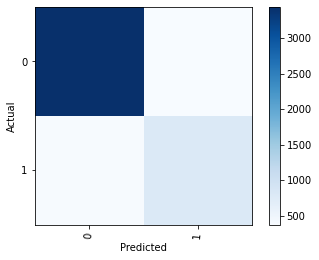

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# batch_size = 64
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 64, SGD

In [ ]:
# batch_size=64
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=64,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=64,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.427117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation set: Average loss: 0.456579, Accuracy: 4244/5000 (85%)

Epoch: 2
Training set: Average loss: 0.424303
Validation set: Average loss: 0.456012, Accuracy: 4238/5000 (85%)

Epoch: 3
Training set: Average loss: 0.423250
Validation set: Average loss: 0.455830, Accuracy: 4235/5000 (85%)

Epoch: 4
Training set: Average loss: 0.422784
Validation set: Average loss: 0.455833, Accuracy: 4230/5000 (85%)

Epoch: 5
Training set: Average loss: 0.422314
Validation set: Average loss: 0.455864, Accuracy: 4233/5000 (85%)

Epoch: 6
Training set: Average loss: 0.422046
Validation set: Average loss: 0.455919, Accuracy: 4233/5000 (85%)

Epoch: 7
Training set: Average loss: 0.422126
Validation set: Average loss: 0.455979, Accuracy: 4237/5000 (85%)

Epoch: 8
Training set: Average loss: 0.421977
Validation set: Average loss: 0.456037, Accuracy: 4233/5000 (85%)

Epoch: 9
Training set: Average loss: 0.421826
Validation set: Average loss: 0.456082, Accuracy: 4233/5000 (85%)

Epoch: 10
Training set: Avera

Evaluation on test dataset
ACCURACY_SCORE:  0.8462
F1_SCORE:  0.7745
CONFUSION_MATRIX:
 [[3525  286]
 [ 483  706]] 

              precision    recall  f1-score   support

           0     0.8795    0.9250    0.9016      3811
           1     0.7117    0.5938    0.6474      1189

    accuracy                         0.8462      5000
   macro avg     0.7956    0.7594    0.7745      5000
weighted avg     0.8396    0.8462    0.8412      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


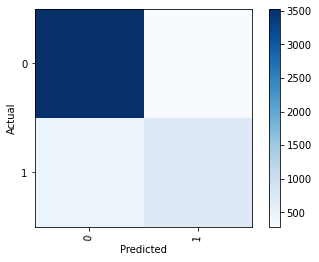

In [ ]:
# batch_size = 512
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 256, SGD

In [ ]:
# batch_size=256
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=256,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=256,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.479674
Validation set: Average loss: 0.458383, Accuracy: 4225/5000 (84%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.455824
Validation set: Average loss: 0.454811, Accuracy: 4256/5000 (85%)

Epoch: 3
Training set: Average loss: 0.451368
Validation set: Average loss: 0.454382, Accuracy: 4259/5000 (85%)

Epoch: 4
Training set: Average loss: 0.448017
Validation set: Average loss: 0.455864, Accuracy: 4231/5000 (85%)

Epoch: 5
Training set: Average loss: 0.446319
Validation set: Average loss: 0.452750, Accuracy: 4259/5000 (85%)

Epoch: 6
Training set: Average loss: 0.442893
Validation set: Average loss: 0.451586, Accuracy: 4256/5000 (85%)

Epoch: 7
Training set: Average loss: 0.441333
Validation set: Average loss: 0.452901, Accuracy: 4248/5000 (85%)

Epoch: 8
Training set: Average loss: 0.439926
Validation set: Average loss: 0.451977, Accuracy: 4248/5000 (85%)

Epoch: 9
Training set: Average loss: 0.439722
Validation set: Average loss: 0.453652, Accuracy: 4253/5000 (85%)

Epoch: 10
Training set: Average loss: 0.438842
Validation set: Average loss: 0.453079, Accuracy: 4252/500

Evaluation on test dataset
ACCURACY_SCORE:  0.8514
F1_SCORE:  0.784
CONFUSION_MATRIX:
 [[3525  286]
 [ 457  732]] 

              precision    recall  f1-score   support

           0     0.8852    0.9250    0.9047      3811
           1     0.7191    0.6156    0.6633      1189

    accuracy                         0.8514      5000
   macro avg     0.8021    0.7703    0.7840      5000
weighted avg     0.8457    0.8514    0.8473      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


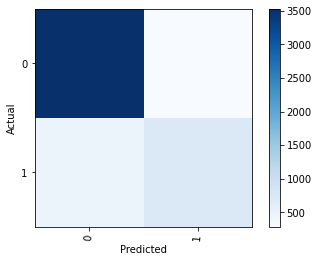

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# batch_size = 64
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### batch_size = 512, SGD

In [ ]:
# batch_size=256
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=512,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=512,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Training set: Average loss: 0.496117
Validation set: Average loss: 0.462323, Accuracy: 4206/5000 (84%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.456637
Validation set: Average loss: 0.459417, Accuracy: 4220/5000 (84%)

Epoch: 3
Training set: Average loss: 0.452928
Validation set: Average loss: 0.456807, Accuracy: 4235/5000 (85%)

Epoch: 4
Training set: Average loss: 0.450733
Validation set: Average loss: 0.460463, Accuracy: 4224/5000 (84%)

Epoch: 5
Training set: Average loss: 0.449967
Validation set: Average loss: 0.453610, Accuracy: 4270/5000 (85%)

Epoch: 6
Training set: Average loss: 0.448563
Validation set: Average loss: 0.453880, Accuracy: 4247/5000 (85%)

Epoch: 7
Training set: Average loss: 0.445738
Validation set: Average loss: 0.453080, Accuracy: 4254/5000 (85%)

Epoch: 8
Training set: Average loss: 0.445186
Validation set: Average loss: 0.450907, Accuracy: 4280/5000 (86%)

Epoch: 9
Training set: Average loss: 0.444745
Validation set: Average loss: 0.453185, Accuracy: 4237/5000 (85%)

Epoch: 10
Training set: Average loss: 0.443730
Validation set: Average loss: 0.453767, Accuracy: 4262/500

Evaluation on test dataset
ACCURACY_SCORE:  0.8492
F1_SCORE:  0.7965
CONFUSION_MATRIX:
 [[3395  416]
 [ 338  851]] 

              precision    recall  f1-score   support

           0     0.9095    0.8908    0.9001      3811
           1     0.6717    0.7157    0.6930      1189

    accuracy                         0.8492      5000
   macro avg     0.7906    0.8033    0.7965      5000
weighted avg     0.8529    0.8492    0.8508      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


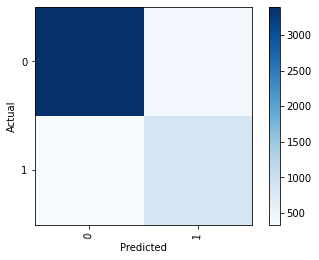

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# batch_size = 64
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

batch_size =256 with optimize = adam have accuracy is the highest

#### 7) Thử nghiệm thêm các layers mà bạn đã học được trong bài này vào kiến trúc của mình.

In [ ]:
hl = 50
# Define the neural network
class IncomeNet_improve(nn.Module):
    def __init__(self):
        super(IncomeNet_improve, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(hl, hl)
        nn.Dropout(0.4)
        self.fc3 = nn.Linear(hl, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.nn.Softmax()(self.fc3(x))
        return x

In [ ]:
# batch_size=256
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=256,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=256,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Create a model instance from the network
model = IncomeNet_improve()
print(model)
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


IncomeNet_improve(
  (fc1): Linear(in_features=108, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Training set: Average loss: 0.554743
Validation set: Average loss: 0.478437, Accuracy: 4157/5000 (83%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.465607
Validation set: Average loss: 0.459678, Accuracy: 4225/5000 (84%)

Epoch: 3
Training set: Average loss: 0.456182
Validation set: Average loss: 0.456353, Accuracy: 4232/5000 (85%)

Epoch: 4
Training set: Average loss: 0.451951
Validation set: Average loss: 0.454578, Accuracy: 4246/5000 (85%)

Epoch: 5
Training set: Average loss: 0.449126
Validation set: Average loss: 0.453893, Accuracy: 4254/5000 (85%)

Epoch: 6
Training set: Average loss: 0.446621
Validation set: Average loss: 0.453382, Accuracy: 4249/5000 (85%)

Epoch: 7
Training set: Average loss: 0.445492
Validation set: Average loss: 0.451787, Accuracy: 4254/5000 (85%)

Epoch: 8
Training set: Average loss: 0.443572
Validation set: Average loss: 0.452239, Accuracy: 4253/5000 (85%)

Epoch: 9
Training set: Average loss: 0.442520
Validation set: Average loss: 0.451523, Accuracy: 4273/5000 (85%)

Epoch: 10
Training set: Average loss: 0.440091
Validation set: Average loss: 0.451335, Accuracy: 4266/500

Evaluation on test dataset
ACCURACY_SCORE:  0.8478
F1_SCORE:  0.7696
CONFUSION_MATRIX:
 [[3576  235]
 [ 526  663]] 

              precision    recall  f1-score   support

           0     0.8718    0.9383    0.9038      3811
           1     0.7383    0.5576    0.6354      1189

    accuracy                         0.8478      5000
   macro avg     0.8050    0.7480    0.7696      5000
weighted avg     0.8400    0.8478    0.8400      5000
 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


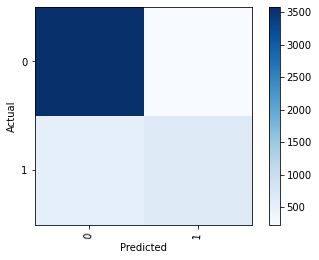

In [ ]:
# batch_size = 256
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

#### 8) Thay đổi các khởi tạo trọng số theo các phân phối khác nhau và đánh giá độ chính xác của kết quả huấn luyện.

In [ ]:
import torch
from torch import nn

def init_weights(m, init_type = 'xavier'):
    if type(m) == nn.Linear:
      if init_type == 'xavier':
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'normal':
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'he':
        m.bias.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)


##### normal distribution 

In [ ]:
model = IncomeNet_improve()
model.apply(lambda m: init_weights(m, init_type = 'normal'))

loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Training set: Average loss: 0.675640
Validation set: Average loss: 0.603044, Accuracy: 3548/5000 (71%)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training set: Average loss: 0.586167
Validation set: Average loss: 0.566788, Accuracy: 3734/5000 (75%)

Epoch: 3
Training set: Average loss: 0.559422
Validation set: Average loss: 0.554717, Accuracy: 3793/5000 (76%)

Epoch: 4
Training set: Average loss: 0.555542
Validation set: Average loss: 0.555299, Accuracy: 3790/5000 (76%)

Epoch: 5
Training set: Average loss: 0.556823
Validation set: Average loss: 0.554256, Accuracy: 3796/5000 (76%)

Epoch: 6
Training set: Average loss: 0.556339
Validation set: Average loss: 0.553824, Accuracy: 3799/5000 (76%)

Epoch: 7
Training set: Average loss: 0.555019
Validation set: Average loss: 0.554164, Accuracy: 3797/5000 (76%)

Epoch: 8
Training set: Average loss: 0.554415
Validation set: Average loss: 0.552415, Accuracy: 3805/5000 (76%)

Epoch: 9
Training set: Average loss: 0.553329
Validation set: Average loss: 0.552288, Accuracy: 3806/5000 (76%)

Epoch: 10
Training set: Average loss: 0.553501
Validation set: Average loss: 0.552086, Accuracy: 3806/500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Evaluation on test dataset
ACCURACY_SCORE:  0.762
F1_SCORE:  0.4357
CONFUSION_MATRIX:
 [[3806    5]
 [1185    4]] 

              precision    recall  f1-score   support

           0     0.7626    0.9987    0.8648      3811
           1     0.4444    0.0034    0.0067      1189

    accuracy                         0.7620      5000
   macro avg     0.6035    0.5010    0.4357      5000
weighted avg     0.6869    0.7620    0.6607      5000
 



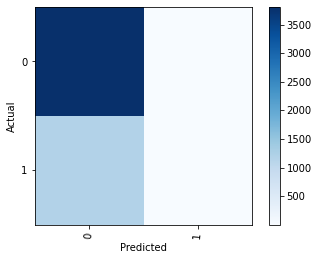

In [ ]:
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

##### xavier distribution

In [ ]:
model = IncomeNet_improve()
model.apply(lambda m: init_weights(m, init_type = 'xavier'))

loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Training set: Average loss: 0.505959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation set: Average loss: 0.467277, Accuracy: 4178/5000 (84%)

Epoch: 2
Training set: Average loss: 0.462923
Validation set: Average loss: 0.460616, Accuracy: 4206/5000 (84%)

Epoch: 3
Training set: Average loss: 0.456418
Validation set: Average loss: 0.458926, Accuracy: 4219/5000 (84%)

Epoch: 4
Training set: Average loss: 0.451613
Validation set: Average loss: 0.456782, Accuracy: 4227/5000 (85%)

Epoch: 5
Training set: Average loss: 0.449099
Validation set: Average loss: 0.456675, Accuracy: 4249/5000 (85%)

Epoch: 6
Training set: Average loss: 0.447249
Validation set: Average loss: 0.456123, Accuracy: 4247/5000 (85%)

Epoch: 7
Training set: Average loss: 0.445667
Validation set: Average loss: 0.456549, Accuracy: 4235/5000 (85%)

Epoch: 8
Training set: Average loss: 0.443408
Validation set: Average loss: 0.455355, Accuracy: 4249/5000 (85%)

Epoch: 9
Training set: Average loss: 0.442191
Validation set: Average loss: 0.453744, Accuracy: 4245/5000 (85%)

Epoch: 10
Training set: Avera

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Evaluation on test dataset
ACCURACY_SCORE:  0.845
F1_SCORE:  0.7784
CONFUSION_MATRIX:
 [[3483  328]
 [ 447  742]] 

              precision    recall  f1-score   support

           0     0.8863    0.9139    0.8999      3811
           1     0.6935    0.6241    0.6569      1189

    accuracy                         0.8450      5000
   macro avg     0.7899    0.7690    0.7784      5000
weighted avg     0.8404    0.8450    0.8421      5000
 



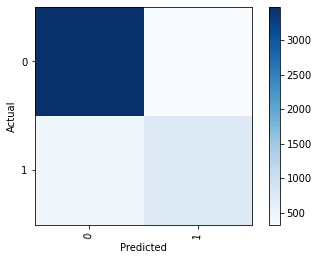

In [ ]:
def _evaluate(model, x_test):
  model.eval()

  x = torch.Tensor(x_test).float()
  _, predictions = torch.max(model(x).data, 1)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

_evaluate(model, x_test)

#### 9) Thiết lập không gian search và tự động hóa tìm kiếm kiến trúc tốt nhất trên optuna.

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
# Reshape y target into [-1, 1] to fit with Binary Cross Entropy
train_y = torch.Tensor(y_train).view(-1, 1).float()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=16,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).view(-1, 1).float()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=16,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 2, 6)
    layers = []

    in_features = len(features)
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 16, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.6)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [ ]:
DEVICE = torch.device("cpu")
BATCHSIZE = 16
EPOCHS = 30
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 300
N_VALID_EXAMPLES = BATCHSIZE * 100

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    loss_criteria = nn.BCELoss()
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            # loss = F.nll_loss(output, target)
            loss = loss_criteria(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = torch.tensor(output.data>=0.5).float()
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-19 16:52:55,652] A new study created in memory with name: no-name-c2654ca5-6561-433e-ad5c-c2a54b9558eb
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-02-19 16:53:51,946] Trial 0 finished with value: 0.83625 and parameters: {'n_layers': 6, 'n_units_l0': 17, 'dropout_l0': 0.5037489524462524, 'n_units_l1': 250, 'dropout_l1': 0.22707355639191787, 'n_units_l2': 41, 'dropout_l2': 0.307229099586679, 'n_units_l3': 143, 'dropout_l3': 0.4669228951876867, 'n_units_l4': 201, 'dropout_l4': 0.34903746525998514, 'n_units_l5': 193, 'dropout_l5': 0.5753719911955282, 'optimizer': 'RMSprop', 'lr': 0.0012927038665341646}. Best is trial 0 with value: 0.83625.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is rec

Study statistics: 
  Number of finished trials:  36
  Number of pruned trials:  25
  Number of complete trials:  11
Best trial:
  Value:  0.859375
  Params: 
    n_layers: 6
    n_units_l0: 130
    dropout_l0: 0.5962398353412779
    n_units_l1: 224
    dropout_l1: 0.43056566016115655
    n_units_l2: 40
    dropout_l2: 0.20931746467633816
    n_units_l3: 140
    dropout_l3: 0.21598451373784883
    n_units_l4: 136
    dropout_l4: 0.22900927956904027
    n_units_l5: 162
    dropout_l5: 0.24356749510358033
    optimizer: RMSprop
    lr: 0.0009295829883427843


In [ ]:
model = define_model(trial)

In [ ]:
loss_criteria = nn.BCELoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=trial.params['lr'])
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 30 epochs
epochs = 30

In [ ]:
def train(model, data_loader, optimizer):
    '''
    Train model through data loader and optimizer
    Args:
      model: model to train
      data_loader: data loader to manage batch loading
      optimizer: control update gradient descent
    '''
    # enable train mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        # reset optimizer into zero
        optimizer.zero_grad()
        # feed forward to compute output and loss
        out = model(data)
        loss = loss_criteria(out, target)
        # accumulate loss
        train_loss += loss.item()
        # compute gradient descent
        loss.backward()
        # update into weight
        optimizer.step()

    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            

In [ ]:
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)
      

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            predicted = torch.tensor(out.data >= 0.5).float()
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
# training through epoch
for epoch in range(1, epochs + 1):
    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.371292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation set: Average loss: 0.333605, Accuracy: 4251/5000 (85%)

Epoch: 2
Training set: Average loss: 0.346428
Validation set: Average loss: 0.316668, Accuracy: 4259/5000 (85%)

Epoch: 3
Training set: Average loss: 0.337579
Validation set: Average loss: 0.317903, Accuracy: 4267/5000 (85%)

Epoch: 4
Training set: Average loss: 0.337365
Validation set: Average loss: 0.314058, Accuracy: 4270/5000 (85%)

Epoch: 5
Training set: Average loss: 0.336444
Validation set: Average loss: 0.329410, Accuracy: 4270/5000 (85%)

Epoch: 6
Training set: Average loss: 0.335988
Validation set: Average loss: 0.317533, Accuracy: 4274/5000 (85%)

Epoch: 7
Training set: Average loss: 0.332751
Validation set: Average loss: 0.344599, Accuracy: 4269/5000 (85%)

Epoch: 8
Training set: Average loss: 0.331192
Validation set: Average loss: 0.338554, Accuracy: 4268/5000 (85%)

Epoch: 9
Training set: Average loss: 0.331541
Validation set: Average loss: 0.322684, Accuracy: 4287/5000 (86%)

Epoch: 10
Training set: Avera

Evaluation on test dataset
ACCURACY_SCORE:  0.856
F1_SCORE:  0.7868
CONFUSION_MATRIX:
 [[3564  247]
 [ 473  716]] 

              precision    recall  f1-score   support

           0     0.8828    0.9352    0.9083      3811
           1     0.7435    0.6022    0.6654      1189

    accuracy                         0.8560      5000
   macro avg     0.8132    0.7687    0.7868      5000
weighted avg     0.8497    0.8560    0.8505      5000
 



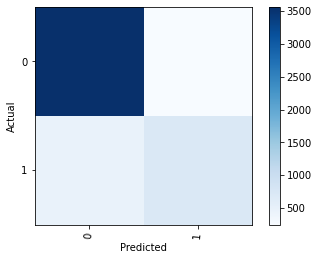

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def _evaluate(model, x_test):
  model.eval()
  x = torch.Tensor(x_test).float()
  predictions = [1 if i>0.5 else 0 for i in model(x).data]
  predictions = torch.tensor(predictions)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()
_evaluate(model, x_test)

#### 10. Deploy model sử dụng flask app

B1. Đăng ký và tạo app trên heroku

B2. Khởi tạo project bao gồm file app.py, 2 file model(scaler, income_model), index.html, requirements.txt, Procfile, runtime.txt
- app.py: chứa hàm khởi chạy app và api để dự đoán
- index.html: phần front_end call api
- Requirements.txt: khai báo các dependencies cần thiết
- Procfile là file thực thi của heroku khi app được lauch.
- runtime.txt: khai báo môi trường chạy
B3. Tạo project trên github sau đó push project vừa tạo lên

B4. Kết nối app với project github

B5. Cuối cùng pull code từ github về heroku và khởi chạy